# Clean version of the auditory debug ntbk

# Text Grid testing

In [67]:
import textgrids as tg
import pandas as pd


files = [f'/home/co/tmp/testing_code/{i}.TextGrid' for i in range(1,4)]

all_starts = []
grid_starts = []
grid_word_count = []

for file in files:
    textgrid = tg.TextGrid(file)
    words = [interval.text for interval in (textgrid['text words']) if interval.text != ""]
    starts = [interval.xmin for interval in (textgrid['text words']) if interval.text != ""]
    all_starts.append(starts)
    grid_word_count.append(len(words))
    
    first_pause = textgrid['text words'][0].xmax
    grid_starts.append(first_pause)
    
grid_length = [starts[-1] - starts[0] for starts in all_starts]

for i in range(len(grid_length)):
    print(f'For run {i+1}')
    print(f'Word count: {grid_word_count[i]}')
    print(f'Grids word length from Praat textgrids: {grid_length[i]} ') 
    print(f'Grid start from audio start to first word: {grid_starts[i]} ') 


For run 1
Word count: 1614
Grid length from Praat textgrids: 607.1500000000001 
Grid start from audio start to first word: 3.05 
For run 2
Word count: 1768
Grid length from Praat textgrids: 640.64 
Grid start from audio start to first word: 3.11 
For run 3
Word count: 1861
Grid length from Praat textgrids: 695.36 
Grid start from audio start to first word: 3.06 


# Wav File testing

In [28]:
import numpy as np 
from scipy.io import wavfile
import matplotlib.pyplot as plt

CHAPTER_PATHS = [
    "ch1-3.wav",
    "ch4-6.wav",
    "ch7-9.wav",
    "ch10-12.wav",
    "ch13-14.wav",
    "ch15-19.wav",
    "ch20-22.wav",
    "ch23-25.wav",
    "ch26-27.wav",
]

audio_word_trigger_length = []
audio_trigger_length = []

for i, chapter in enumerate(CHAPTER_PATHS):
    wav_file = f'/home/co/data/neuralset/LPP_copy/PallierListen2023/download/sourcedata/stimuli/audio/{chapter}'
    duration = get_wav_duration(wav_file)
    fs, data = wavfile.read(wav_file)

    # Getting the channel for the triggers encoded in the 2nd part of the wav
    data = data[:,1]
    data = np.round(data / 30000)
    diff = np.diff(data)
    audio_triggers = np.where(diff == 1)[0]
    word_total_length =  (audio_triggers[-1] - audio_triggers[0] )/ fs
    
    audio_word_trigger_length.append(word_total_length)
    audio_trigger_length.append(duration)
    print(f'For run: {i+1}')
    print(f'Word count:' , len(audio_triggers))
    print("Length of word triggers in the audio file : ", word_total_length)
    print("TOTAL Length of the audio file : ", duration)
    print(f'Wav start from audio start to first word: {audio_triggers[0] / fs} ') 

    

For run: 1
Word count: 1614
Length of word triggers in the audio file :  607.15
TOTAL Length of the audio file :  613.5172789115646
Wav start from audio start to first word: 3.0499773242630384 
For run: 2
Word count: 1768
Length of word triggers in the audio file :  640.64
TOTAL Length of the audio file :  647.0398412698413
Wav start from audio start to first word: 3.1099773242630384 
For run: 3
Word count: 1861
Length of word triggers in the audio file :  695.36
TOTAL Length of the audio file :  702.2595011337869
Wav start from audio start to first word: 3.0599773242630386 
For run: 4
Word count: 1641
Length of word triggers in the audio file :  617.63
TOTAL Length of the audio file :  624.4917233560091
Wav start from audio start to first word: 3.0699773242630384 
For run: 5
Word count: 1520
Length of word triggers in the audio file :  574.5
TOTAL Length of the audio file :  580.9757596371882
Wav start from audio start to first word: 3.0799773242630386 
For run: 6
Word count: 1845
Len

# Metadata testing

There is an inherent problem that I could fix with the metadata. In the textgrid, there is a weird jump with du (it is always followed by an empty event "").

I added it to the metadata, but it is not present in the triggers. It means a difference of ~40 words that are missed when matching on metadata with triggers. 

In [80]:
path = "/home/co/data/LPP_MEG_auditory/sub-1/ses-01/meg/sub-1_ses-01_task-listen_run-"

for run in range(1,10):
    file = path + f'0{run}_events.tsv'
    meta = pd.read_csv(file, sep='\t')
    meta['start'] = meta.onset
    
    # Trying to remove the additional empty word
    
    meta_triggers = meta.start
    print(f'For run {run}')
    print(f'Word count: {meta.shape[0]}')
    print(f'Meta length from metadata file: {(meta_triggers.iloc[-1] - meta_triggers.iloc[0])} ') 
    print(f'Metadata start from audio start to first word: {meta_triggers[0]} ') 

For run 1
Word count: 1632
Meta length from metadata file: 607.1500000000001 
Metadata start from audio start to first word: 3.05 
For run 2
Word count: 1787
Meta length from metadata file: 640.64 
Metadata start from audio start to first word: 3.11 
For run 3
Word count: 1876
Meta length from metadata file: 695.36 
Metadata start from audio start to first word: 3.06 
For run 4
Word count: 1650
Meta length from metadata file: 617.63 
Metadata start from audio start to first word: 3.07 
For run 5
Word count: 1527
Meta length from metadata file: 574.5 
Metadata start from audio start to first word: 3.08 
For run 6
Word count: 1858
Meta length from metadata file: 743.53 
Metadata start from audio start to first word: 3.13 
For run 7
Word count: 1712
Meta length from metadata file: 651.27 
Metadata start from audio start to first word: 3.12 
For run 8
Word count: 1539
Meta length from metadata file: 575.98 
Metadata start from audio start to first word: 3.1 
For run 9
Word count: 1810
Meta

# Triggers testing

In [38]:
import mne
import logging
import mne_bids
# Set the logger level to WARNING to reduce verbosity
logger = logging.getLogger('mne')
logger.setLevel(logging.ERROR)

subject = '2'

all_triggers = []  # All the trigger timings
all_word_triggers = []  # All the word triggers
trigger_starts = []  # The time of between first trigger (beginning of audio) and first word
triggers_word_count = []  # The total number of word triggers for each run
all_word_trigger_length = []  # The total length from the first word trigger to the last one
all_trigger_length = []  # The total length from the first trigger to the last one (the whole audio file)

for run in range(1,10):
    run_id = '0'+ str(run)
    # Audio data
    
    audio_data = get_audio_timestamps(subject, run_id)
    
    # Triggers words
    f, triggers = get_triggers(subject, run_id)
    all_triggers.append(triggers)
    
    word_triggers = triggers[triggers[:, 2] > 1][:,0]
    all_word_triggers.append(word_triggers)
    
    first_diff = (triggers[1][0] - triggers[0][0]) / f
    trigger_starts.append(first_diff)
    
    triggers_word_count.append(word_triggers.shape[0])
    
    word_trigger_length = (word_triggers[-1] - word_triggers[0]) / f
    all_word_trigger_length.append(word_trigger_length)
    
    total_length = triggers[-1][0] - triggers[0][0]
    all_trigger_length.append(total_length)
        
for i in range(len(all_word_trigger_length)):
    print(f'For run {i}')
    print(f'Number of word triggers: {triggers_word_count[i]} ') 
    print(f'Trigger start from audio start to first word: {trigger_starts[i]} ') 
    print(f'Total length of words triggers: {all_word_trigger_length[i]}')
    print(f'Total length from first triger to the last: {all_trigger_length[i] / f}')

For run 0
Number of word triggers: 1645 
Trigger start from audio start to first word: 3.272 
Total length of words triggers: 608.175
Total length from first triger to the last: 614609
For run 1
Number of word triggers: 1800 
Trigger start from audio start to first word: 3.292 
Total length of words triggers: 641.663
Total length from first triger to the last: 648093
For run 2
Number of word triggers: 1948 
Trigger start from audio start to first word: 3.273 
Total length of words triggers: 696.693
Total length from first triger to the last: 703656
For run 3
Number of word triggers: 1786 
Trigger start from audio start to first word: 3.264 
Total length of words triggers: 618.564
Total length from first triger to the last: 625497
For run 4
Number of word triggers: 1636 
Trigger start from audio start to first word: 3.282 
Total length of words triggers: 575.206
Total length from first triger to the last: 581768
For run 5
Number of word triggers: 1972 
Trigger start from audio start to 

# Comparaisons

Let's compare the difference between the trigger length recorded vs theoritical, between runs / subjects

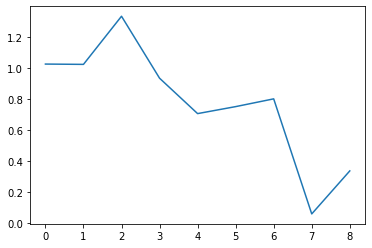

In [84]:
timing_diff = [all_word_trigger_length[run] - audio_word_trigger_length[run] for run in range(9)]

plt.plot(timing_diff)

# Subject analysis


In [14]:
# Loading the pre-computed array of results, no need to reload every raw file

# Load the NumPy array from a file in binary format
arr = np.load('results.npy', allow_pickle=True)

# Convert the NumPy array to a list of dictionaries
rst = arr.tolist()


[{'all_triggers': [array([[ 86949,      0,      1],
       [ 90157,      0,    128],
       [ 90164,      0,    128],
       ...,
       [697296,      0,    128],
       [697303,      0,    128],
       [700533,      0,      1]]), array([[ 22381,      0,      1],
       [ 25633,      0,    128],
       [ 25743,      0,    128],
       ...,
       [665741,      0,    128],
       [666261,      0,    128],
       [669465,      0,      1]]), array([[ 16924,      0,      1],
       [ 20127,      0,    128],
       [ 20337,      0,    128],
       ...,
       [715467,      0,    128],
       [715474,      0,    128],
       [719229,      0,      1]]), array([[ 10459,      0,      1],
       [ 13676,      0,    128],
       [ 13876,      0,    128],
       ...,
       [631287,      0,    128],
       [631294,      0,    128],
       [635009,      0,      1]]), array([[ 15247,      0,      1],
       [ 18487,      0,    128],
       [ 18494,      0,    128],
       ...,
       [592976,      0

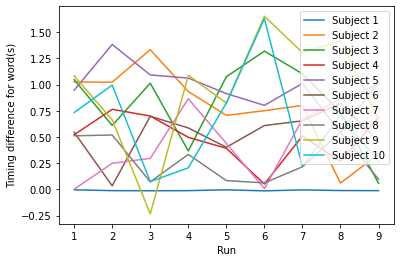

In [30]:
plot_timing_diff(all_results[:10], 'word')

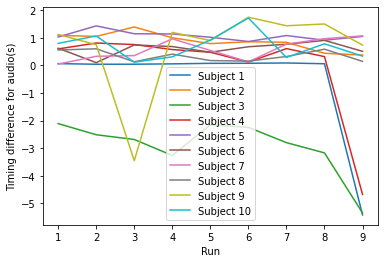

In [47]:
plot_timing_diff(all_results[:10], 'audio')

In [26]:
# Sub 1 seems to have no shift.. let's investigate

sub1_data = all_results[0]

sub1_run1_audio_length = sub1_data['all_triggers'][0][-1][0] - sub1_data['all_triggers'][0][0][0]

sub1_run1_words_length = sub1_data['all_word_triggers'][0][-1] - sub1_data['all_word_triggers'][0][0]

# Solution

We could try to, for each subject, each run, find the linear shift and apply it to the metadata: we align the first trigger (start in STI001), and then apply the metadata starts * modified sfreq.

To do so, we need to study first if for each subject, the shift throughout the run is always linear.

Then, for one subject, through runs.

## Studying the shift through subject for run 1

Found 0.2905824039653036 of the words in the triggers
Found 0.9473358116480793 of the words in the triggers
Found 0.7205700123915737 of the words in the triggers
Found 0.9981412639405205 of the words in the triggers
Found 0.8574969021065675 of the words in the triggers
Found 0.9944237918215614 of the words in the triggers
Found 0.9975216852540273 of the words in the triggers
Found 0.9969021065675341 of the words in the triggers
Found 0.9913258983890955 of the words in the triggers
Found 0.9956629491945477 of the words in the triggers
Found 0.9584882280049566 of the words in the triggers
Found 0.8413878562577447 of the words in the triggers
Found 0.9969021065675341 of the words in the triggers
Found 0.9975216852540273 of the words in the triggers
Found 0.9962825278810409 of the words in the triggers
Found 0.9987608426270136 of the words in the triggers
Found 0.9919454770755886 of the words in the triggers
Found 0.9969021065675341 of the words in the triggers
Found 0.9969021065675341 of 

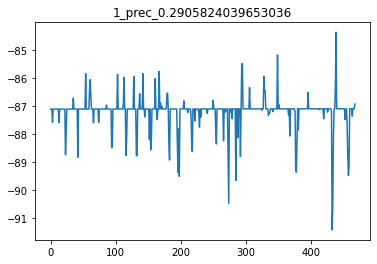

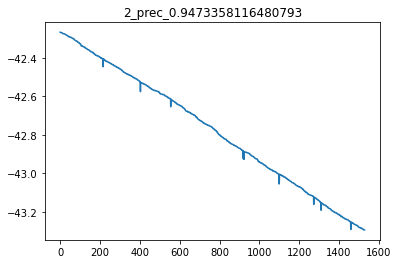

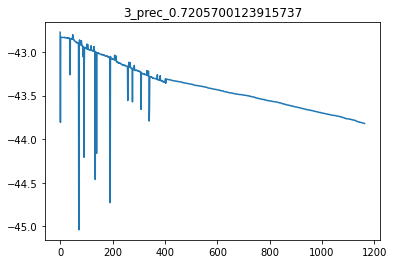

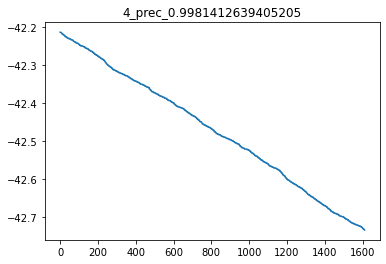

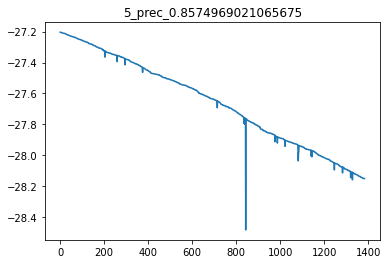

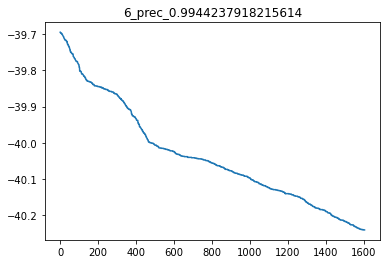

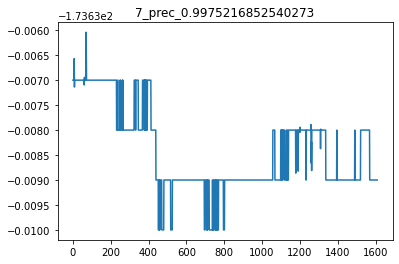

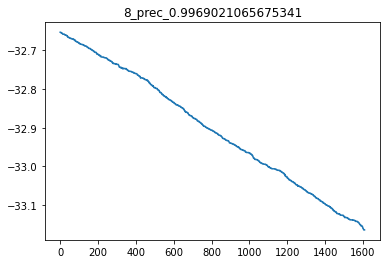

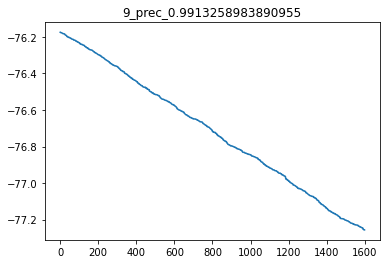

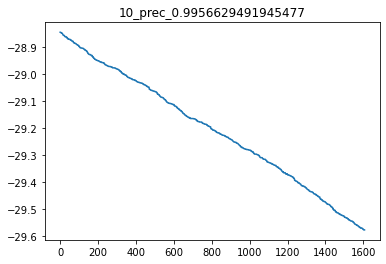

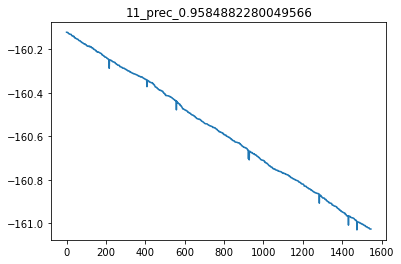

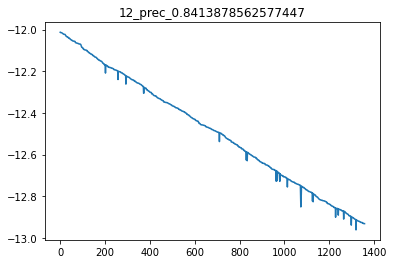

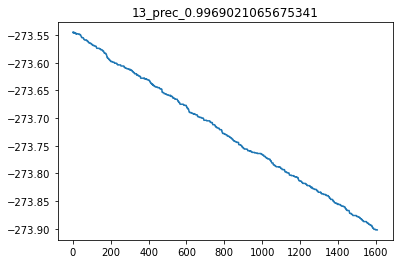

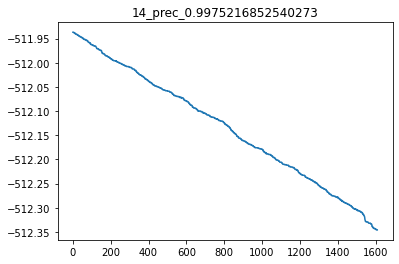

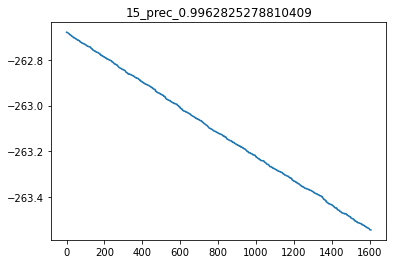

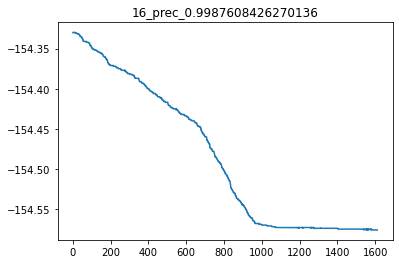

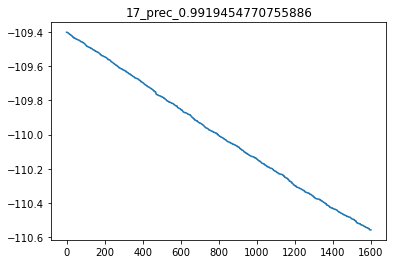

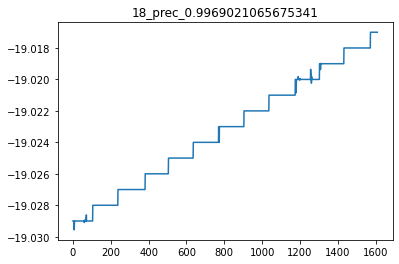

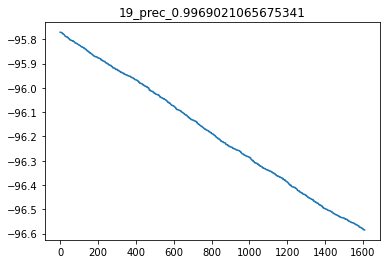

In [101]:
import matplotlib.pyplot as plt

for subject in range(1, 20):
    subject = str(subject)

    # Create a new figure object and set it as the current figure
    plt.figure()

    # Plot the data for the current subject
    diff, prec = get_trigger_diff_array(subject=subject)
    plt.plot(diff)
    plt.title(f"{subject}_prec_{prec}")
    # Save the figure to a file
    plt.savefig(f'./figures/{subject}.png')


# Functions

In [100]:
from pathlib import Path
import mne_bids
import mne

import pandas as pd
from utils import match_list


#path = '/home/co/data/LPP_MEG_auditory'
path = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")


def get_trigger_diff_array(subject):
    run_id = '01'
    path = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")

    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )

    raw = mne_bids.read_raw_bids(bids_path)
    # triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

    # Generate event_file path
    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()

    meta = pd.read_csv(event_file, sep="\t")

    meta["word"] = meta["trial_type"].apply(
            lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

    # Trying to remove the empty words:
    
    meta.loc[meta['word'] == ' ', 'word'] = None

    # Drop the rows containing NaN values in the text column
    meta = meta.dropna(subset=['word'])

    meta['start'] = meta.onset

    words = meta

    events_df = meta
    # Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
    word_triggers = triggers[triggers[:, 2] > 1]


    # Matching triggers and metadata


    decimals = 2
    triggers_delta = np.round(np.diff(word_triggers[:, 0] / raw.info["sfreq"]), decimals=decimals)  # type: ignore
    events_delta = np.round(np.diff(words.start.values), decimals=decimals)  # type: ignore
    i, j = match_list(triggers_delta, events_delta)

    print(f"Found {len(i)/len(words)} of the words in the triggers")

    true_indices = words.iloc[j].index

    # Find the missing words df
    opposite_indices = events_df.index.difference(true_indices)
    opposite_events_df = events_df.loc[opposite_indices]


    events_df = events_df.loc[true_indices].copy()

    events_df.loc[true_indices, "start"] = (
        word_triggers[i, 0] / raw.info["sfreq"]
    )


    # Match on text the events_df df with the initial metadata, to have info how it shifts

    metadata_words = meta
    matched_words = events_df

    # Match list between the two events arrays
    idx2, idx = match_list((metadata_words.word.values), (matched_words.word.values))

    # Return the diff arrays
    diff_array = metadata_words.start.values[idx2] - matched_words.start.values[idx]
    return diff_array, len(i)/len(words)

def get_triggers(subject, run_id):
    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )
    raw = mne_bids.read_raw_bids(bids_path)
    triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    sfreq = raw.info['sfreq']
    
    return sfreq, triggers

def get_audio_timestamps(subject, run_id):
    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )
    raw = mne_bids.read_raw_bids(bids_path)
    audio_data = raw.get_data(picks=["MISC004"])[0,:]

    sfreq = raw.info['sfreq']
    
    return sfreq, audio_data

def get_raw(subject, run_id):
    task = 'listen'
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )
    raw = mne_bids.read_raw_bids(bids_path)
    return raw


import wave

def get_wav_duration(filename):
    with wave.open(filename, 'rb') as wav_file:
        # Get the total number of frames in the WAV file
        frames = wav_file.getnframes()
        
        # Get the frame rate (number of frames per second)
        frame_rate = wav_file.getframerate()
        
        # Calculate the duration in seconds
        duration = frames / float(frame_rate)
        
        return duration
    
    import matplotlib.pyplot as plt

def plot_timing_diff(all_results, target):
    num_subjects = len(all_results)
    num_runs = 9

    # Create an empty list to store the timing differences for all subjects and runs
    timing_diffs = [[] for _ in range(num_subjects)]

    # Loop over all subjects and runs
    for subject_idx, subject_results in enumerate(all_results):
        for run in range(1, num_runs + 1):
            
            if target == 'word':
                # Extract the word trigger length and audio word trigger length for the current run
                word_trigger_length = subject_results['all_word_trigger_length'][run - 1]
                audio_word_trigger_length_ = audio_word_trigger_length[run - 1]

                # Calculate the timing difference
                timing_diff_ = word_trigger_length - audio_word_trigger_length_

            if target == 'audio':
                audio_trigger_length_meg = subject_results['all_trigger_length'][run - 1]
                audio_trigger_length_ = audio_trigger_length[run - 1]

                # Calculate the timing difference
                timing_diff_ = (audio_trigger_length_meg / 1000) - audio_trigger_length_
                
                
            timing_diffs[subject_idx].append(timing_diff_)
            
            
    # Loop over all subjects and plot the timing differences for each run
    for subject_idx, timing_diff in enumerate(timing_diffs):
        plt.plot(range(1, num_runs + 1), timing_diff, label=f'Subject {subject_idx + 1}')

    # Add a legend and labels to the plot
    plt.legend()
    plt.xlabel('Run')
    plt.ylabel(f'Timing difference for {target}(s)')
    plt.show()



In [6]:
import mne
import logging
import mne_bids
# Set the logger level to WARNING to reduce verbosity
logger = logging.getLogger('mne')
logger.setLevel(logging.ERROR)


all_results = []

for subject in range(1,20):
    subject = str(subject)
    all_triggers = []  # All the trigger timings
    all_word_triggers = []  # All the word triggers
    trigger_starts = []  # The time of between first trigger (beginning of audio) and first word
    triggers_word_count = []  # The total number of word triggers for each run
    all_word_trigger_length = []  # The total length from the first word trigger to the last one
    all_trigger_length = []  # The total length from the first trigger to the last one (the whole audio file)

    subject_results = {}  # Create an empty dictionary for the subject results
    
    for run in range(1,10):
        run_id = '0'+ str(run)

        # Triggers words
        f, triggers = get_triggers(subject, run_id)
        all_triggers.append(triggers)

        word_triggers = triggers[triggers[:, 2] > 1][:,0]
        all_word_triggers.append(word_triggers)

        first_diff = (triggers[1][0] - triggers[0][0]) / f
        trigger_starts.append(first_diff)

        triggers_word_count.append(word_triggers.shape[0])

        word_trigger_length = (word_triggers[-1] - word_triggers[0]) / f
        all_word_trigger_length.append(word_trigger_length)

        total_length = triggers[-1][0] - triggers[0][0]
        all_trigger_length.append(total_length)

    # Add the results to the subject dictionary
    subject_results['all_triggers'] = all_triggers
    subject_results['all_word_triggers'] = all_word_triggers
    subject_results['trigger_starts'] = trigger_starts
    subject_results['triggers_word_count'] = triggers_word_count
    subject_results['all_word_trigger_length'] = all_word_trigger_length
    subject_results['all_trigger_length'] = all_trigger_length

    all_results.append(subject_results)
